**Meaning of Data Columns**

- SD: Sus domain i.e. words associated to hacking
- JD: Job domain i.e. words associated with job portals
- CD: Cloud domain i.e. words associated with cloud drives

- WKE: user accessed during weekends
- OWH: user accessed out of work hours (of work days)
- WH: user accessed during work hours

**Import Feature Engineered Data**
- OCEAN Personality Test
- File
- HTTP

In [1]:
import pandas as pd
data = pd.read_parquet('../data/FEData_For_Modelling.parquet').reset_index(drop = True)
data

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810


Get a list of malicious users from answers dataset
- Identified in scenario 2

In [2]:
import os
malicious_filenames = os.listdir('../data/answers')
malicious_users = []

for filename in malicious_filenames:
    malicious_users.append(filename.replace('r5.2-2-', "").replace('.csv', ""))

malicious_users

['MDS0680',
 'GWG0497',
 'CKP0630',
 'HMS1658',
 'BYO1846',
 'HXP0976',
 'CIF1430',
 'ITA0159',
 'OSS1463',
 'SNK1280',
 'HIS1394',
 'SIS0042',
 'HSN0675',
 'MCP0611',
 'TNB1616',
 'CHP1711',
 'MGB1235',
 'NAH1366',
 'JAL0811',
 'OKM1092',
 'TMT0851',
 'DCC1119',
 'KSS1005',
 'VCF1602',
 'RRS0056',
 'WDT1634',
 'ICB1354',
 'ZIE0741',
 'LVF1626',
 'TRC1838']

**Add 'malicous column' to identify such users**
- 1: malicous
- 2: not malicious

In [22]:
import numpy as np

data['malicious'] = np.where(data['user'].isin(malicious_users), 1, 0)
data

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,0
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,0
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,0
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,0
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,0
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,0
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,0
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810,0


In [4]:
data[data.user == 'TRC1838']

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
1820,TRC1838,17,30,42,30,23,0,0,165,0,0,58,0,0,12,0,0,757,1


# Decision Tree / Random Forest

In [5]:
from sklearn.model_selection import train_test_split
from collections import Counter

X = data.drop(columns = ['user', 'malicious'])
y = data.malicious

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train Labels before Resampling")
print(Counter(y_train))

Train Labels before Resampling
Counter({0: 1574, 1: 26})


**SMOTE Oversampling**
- Not included for now

In [6]:
# from imblearn.over_sampling import SMOTE

# # transform the dataset
# oversample = SMOTE(sampling_strategy=0.8) #sampling_strategy=0.8
# resampled_X_train, resampled_y_train = oversample.fit_resample(X_train, y_train)

# print("Train Labels after Resampling")
# print(Counter(resampled_y_train))

**Feature Normalisation**

In [7]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Recursive Feature Elimination + Cross Validation**

In [8]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Feature Selection
dt = DecisionTreeClassifier()
# dt = RandomForestClassifier()
rfe = RFECV(estimator = dt, scoring = 'precision') #minimises false positives
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

print('Chosen best features by rfe:', X_train.columns[rfe.support_].tolist())
print('Ranking of Feature Importance:', rfe.ranking_)

Chosen best features by rfe: ['O', 'E', 'FCwh', 'SDwh']
Ranking of Feature Importance: [ 1  3  1 13  6 12  2  1 14 11  1 10  9  5  8  7  4]


**Model Evaluation**

Accuracy: 98.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       396
           1       0.00      0.00      0.00         4

    accuracy                           0.98       400
   macro avg       0.49      0.49      0.49       400
weighted avg       0.98      0.98      0.98       400



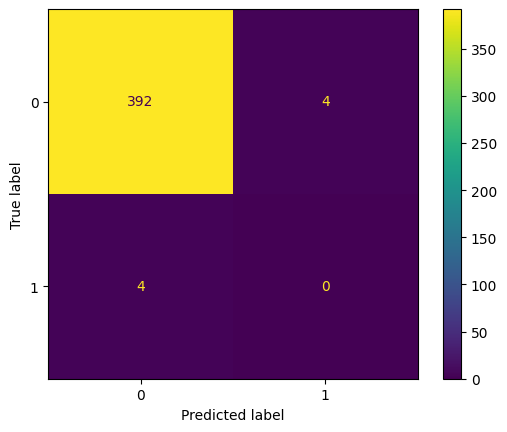

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model
dt.fit(X_train_rfe, y_train)
y_pred = dt.predict(X_test_rfe)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp.plot()
plt.show()

**Hyperparameter Tuning**

In [10]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV with 10-fold cross-validation
grid_search = GridSearchCV(dt, param_grid, cv=10, scoring = "precision")
grid_search.fit(X_train_rfe, y_train)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_dt = grid_search.best_estimator_
test_score = best_dt.score(X_test_rfe, y_test)
print("Test Set Score:", test_score)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Best Hyperparameters: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 5}
Best Score: 0.5083333333333333
Test Set Score: 0.985


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Model Evaluation after Tuning**

Accuracy: 98.50%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       396
           1       0.25      0.25      0.25         4

    accuracy                           0.98       400
   macro avg       0.62      0.62      0.62       400
weighted avg       0.98      0.98      0.98       400



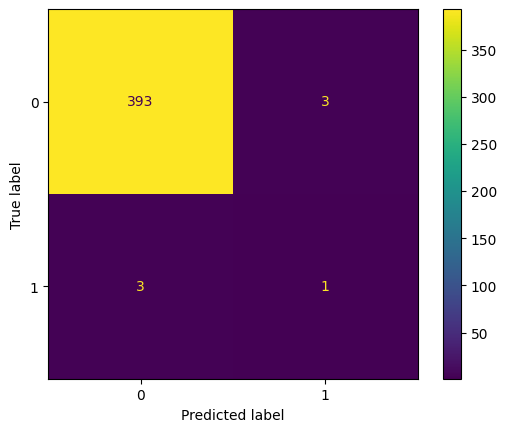

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model
best_dt.fit(X_train_rfe, y_train)
y_pred = best_dt.predict(X_test_rfe)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp.plot()
plt.show()

**Visualise Graph**

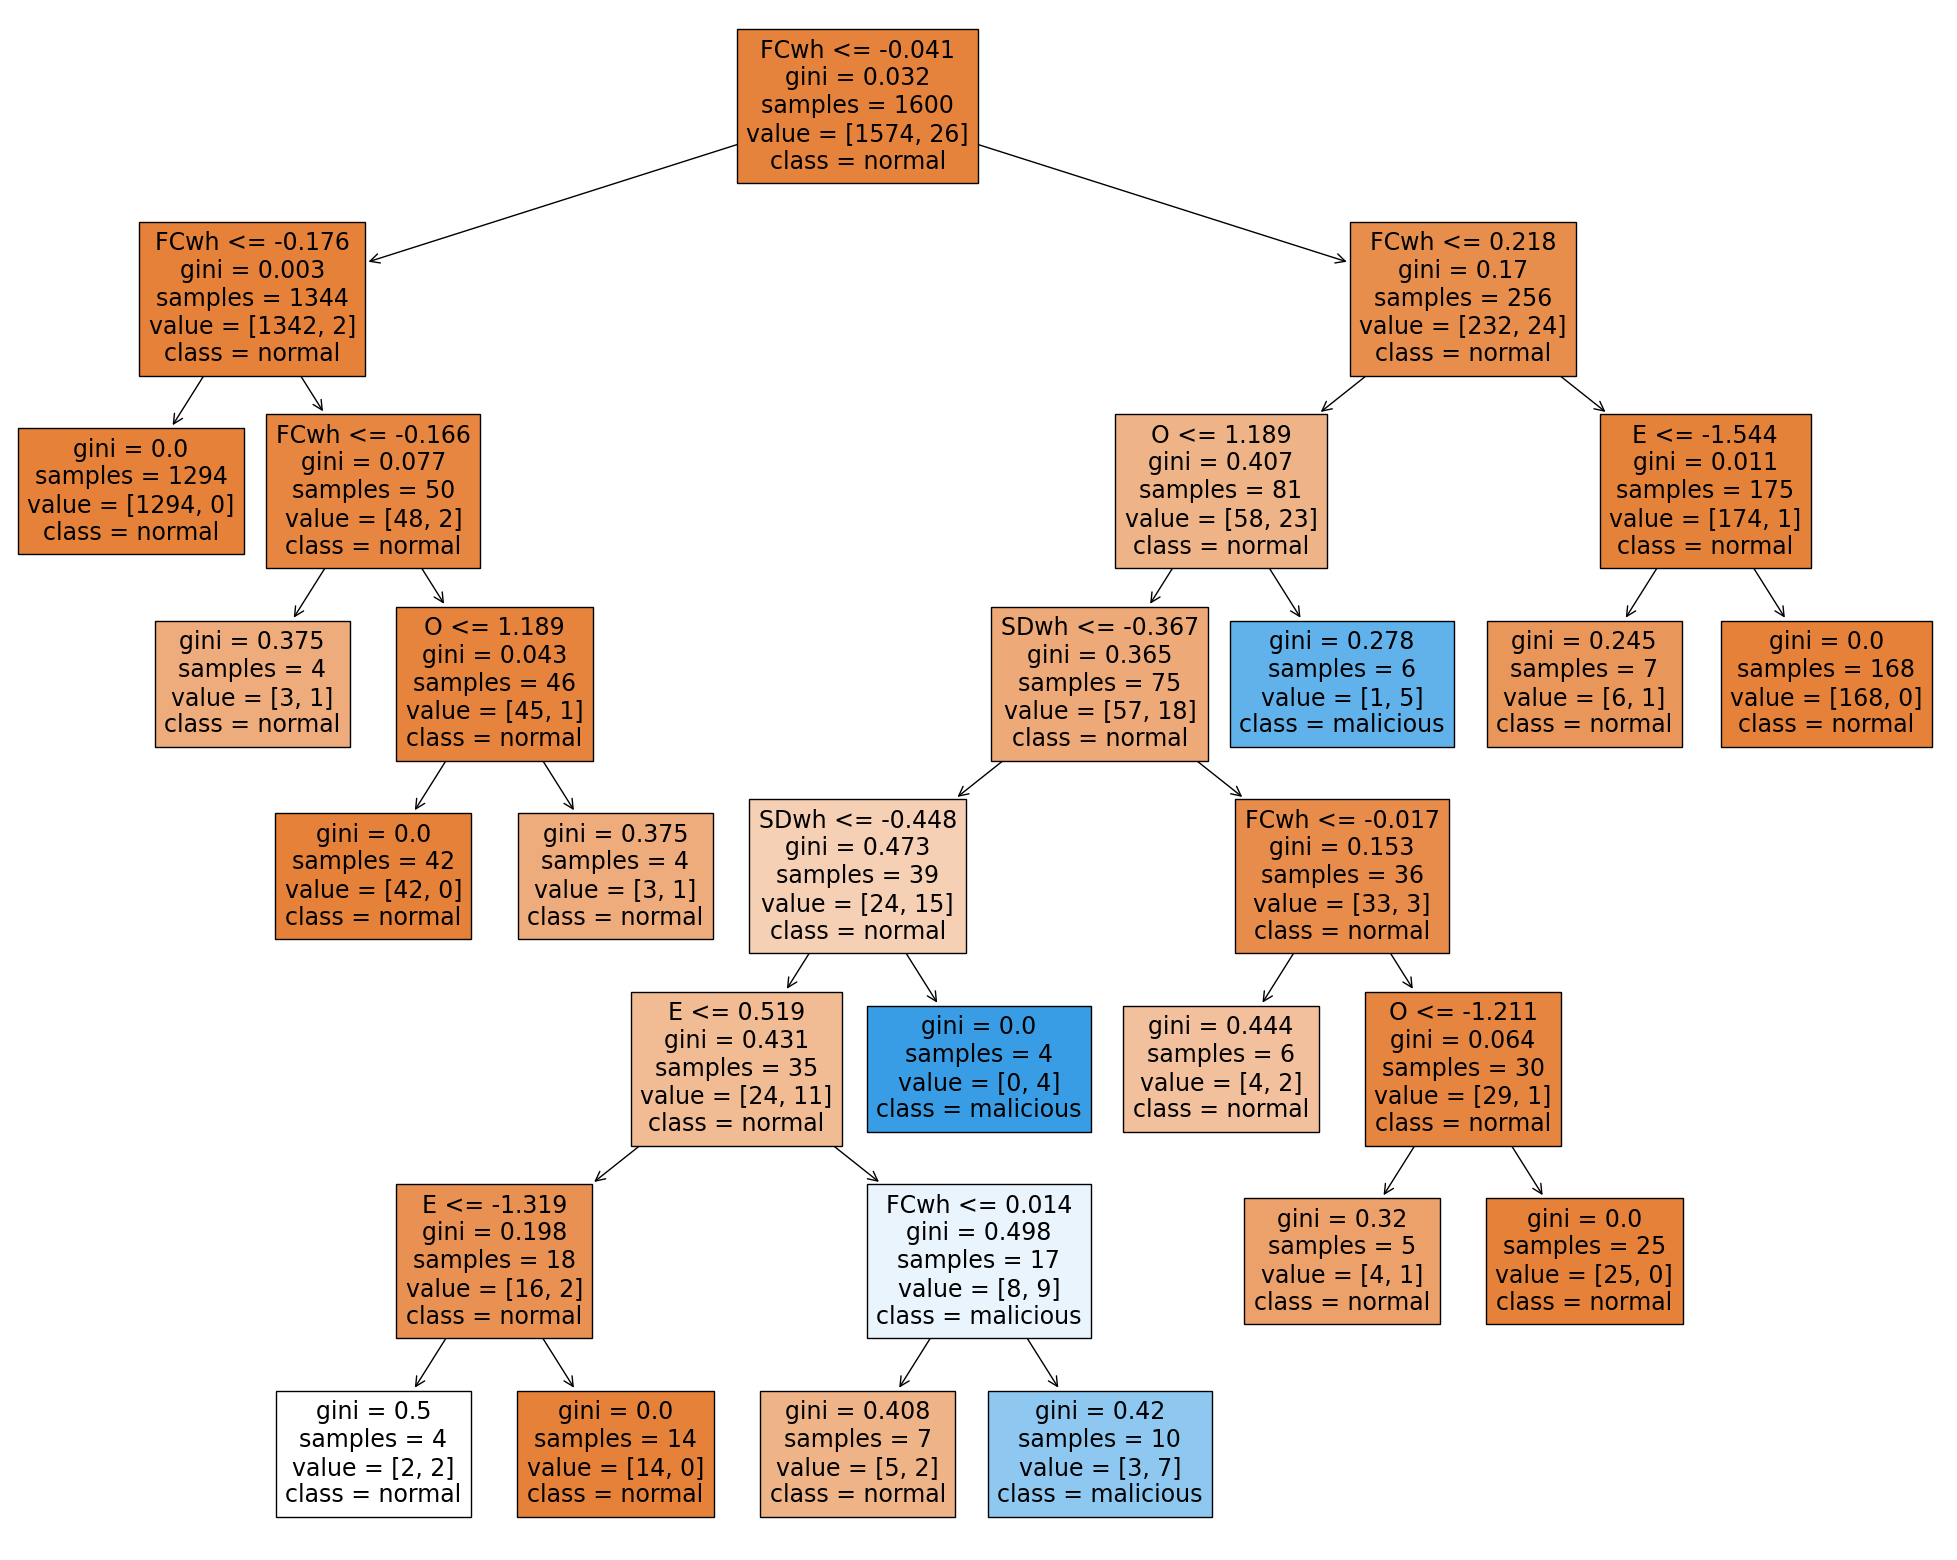

In [17]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_dt, 
                   feature_names=X_train.columns[rfe.support_].tolist(),  
                   class_names=["normal","malicious"],
                   filled=True)

**Calculate Risk Score**
- A higher impurity indicates a higher risk or uncertainty in the classification decision made by that node.
- This calculation takes into account the number of samples each node represents, weighting the impurity of each node accordingly.

In [19]:
n_nodes = best_dt.tree_.node_count
impurity = best_dt.tree_.impurity

weighted_impurity = sum(best_dt.tree_.n_node_samples[i] * impurity[i] for i in range(n_nodes)) / sum(best_dt.tree_.n_node_samples)
print(f"Weighted Average Gini Impurity: {weighted_impurity}")

Weighted Average Gini Impurity: 0.04432504705070072


# Note: Libraries to be Installed

In [ ]:
# %pip install scikit-learn
# %pip install matplotlib
# %pip install imblearn - depends on whether used

  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)
Note: you may need to restart the kernel to use updated packages.
